In [28]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn import preprocessing

import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import Normalize, Resize, ToTensor
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [29]:
mars_weather_df = pd.read_csv("../local_datasets/mars_weather_data_cleaned.csv")

In [30]:
mars_weather_df.columns

Index(['Unnamed: 0', 'id', 'terrestrial_date', 'sol', 'ls', 'season',
       'min_temp', 'max_temp', 'pressure', 'pressure_string', 'abs_humidity',
       'wind_speed', 'wind_direction', 'atmo_opacity', 'sunrise', 'sunset',
       'local_uv_irradiance_index', 'min_gts_temp', 'max_gts_temp'],
      dtype='object')

In [31]:
mars_weather_df = mars_weather_df[
    ["terrestrial_date", "sol", "min_temp", "max_temp", "pressure", "min_gts_temp", "max_gts_temp"]
]

In [32]:
print(mars_weather_df.shape)
mars_weather_df.head()

(2950, 7)


,terrestrial_date,sol,min_temp,max_temp,pressure,min_gts_temp,max_gts_temp
0,2012-08-16,10,-75,-16,739,-83,8
1,2012-08-17,11,-76,-11,740,-83,9
2,2012-08-18,12,-76,-18,741,-82,8
3,2012-08-19,13,-74,-15,732,-80,8
4,2012-08-20,14,-74,-16,740,-82,9


In [33]:
mars_weather_df.isnull().sum(axis=0)

terrestrial_date    0
sol                 0
min_temp            0
max_temp            0
pressure            0
min_gts_temp        0
max_gts_temp        0
dtype: int64

In [34]:
mars_weather_df["terrestrial_date"] = pd.to_datetime(mars_weather_df["terrestrial_date"])

In [35]:
mars_weather_df = mars_weather_df[
    (mars_weather_df.terrestrial_date > "2013-06-01") & (mars_weather_df.terrestrial_date < "2018-06-01")
]

In [36]:
mars_weather_df.terrestrial_date.min(), mars_weather_df.terrestrial_date.max()

(Timestamp('2013-06-02 00:00:00'), Timestamp('2018-05-31 00:00:00'))

## Feature Engineering
- Sin and cosing transformation of time of year to encode cyclical nature of the data into a feature used to train the model. 

In [37]:
mars_weather_df["timestamp"] = mars_weather_df.terrestrial_date.apply(lambda x: x.timestamp())

num_seconds_in_an_earth_year = 60 * 60 * 24 * 365.25

sin_transformation = lambda x: np.sin(
    (2 * np.pi * x) / num_seconds_in_an_earth_year
)

cos_transformation = lambda x: np.cos(
    (2 * np.pi * x) / num_seconds_in_an_earth_year
)

mars_weather_df["timestamp_sin"] = mars_weather_df.timestamp.apply(sin_transformation)
mars_weather_df["timestamp_cos"] = mars_weather_df.timestamp.apply(cos_transformation)

mars_weather_df.head()

,terrestrial_date,sol,min_temp,max_temp,pressure,min_gts_temp,max_gts_temp,timestamp,timestamp_sin,timestamp_cos
245,2013-06-02,292,-71,-1,853,-71,-1,1.370131e+09,0.499069,-0.866562
246,2013-06-03,293,-72,-4,850,-72,0,1.370218e+09,0.484089,-0.875019
247,2013-06-04,294,-72,-4,852,-71,-1,1.370304e+09,0.468965,-0.883217
248,2013-06-05,295,-71,-15,853,-71,-1,1.370390e+09,0.453703,-0.891153
249,2013-06-06,296,-71,-9,850,-73,1,1.370477e+09,0.438307,-0.898825


## Prepare data 

In [38]:
def create_train_test_split(data_df, train_prop): 
    test_prop = 1 - train_prop
    train_data_df = data_df.iloc[:int(len(data_df) * train_prop)]
    test_data_df = data_df.iloc[len(train_data_df):]
    
    return train_data_df, test_data_df

In [39]:
def scale_data(train_data, test_data, scaling):
    if scaling == "Standardise": 
        train_mean = train_data.mean()
        train_std = train_data.std()
        
        train_data_scaled = (train_data - train_mean) / train_std
        test_data_scaled = (test_data - train_mean) / train_std
        
    if scaling == "Normalise": 
        train_min = train_data.min()
        train_max = train_data.max()
        
        train_data_scaled = (train_data - train_min) / (train_max - train_min)
        test_data_scaled = (test_data - train_min) / (train_max - train_min)

    
    return train_data_scaled, test_data_scaled        

In [40]:
def construct_training_sequences_and_labels(df, quantity, lags, num_timesteps_to_forecast): 
    train_x = []
    train_y = []
    
    df_reset_index = df.reset_index(drop=True)
    quantity_series = df_reset_index[quantity].values
    
    for i in range(len(quantity_series) - lags - num_timesteps_to_forecast): 
        seq_x = df_reset_index.iloc[i:(i + lags)].values
        seq_y = quantity_series[(i + lags):(i + lags + num_timesteps_to_forecast)]
        
        train_x.append(seq_x)
        train_y.append(seq_y)
        
    return np.array(train_x), np.array(train_y)

In [41]:
quantity_to_forecast = "min_temp"
features = ["timestamp_sin", "timestamp_cos"]
mars_weather_df_forecast = mars_weather_df[[quantity_to_forecast] + features]
mars_weather_df_forecast.reset_index(inplace=True, drop=True)

train_df, test_df = create_train_test_split(mars_weather_df_forecast, train_prop=0.7)

val_df, test_df = create_train_test_split(test_df, train_prop=0.5)

In [42]:
train_x, train_y = construct_training_sequences_and_labels(
    train_df, quantity_to_forecast, lags=10, num_timesteps_to_forecast=1
)

val_x, val_y = construct_training_sequences_and_labels(
    val_df, quantity_to_forecast, lags=10, num_timesteps_to_forecast=1
)

test_x, test_y = construct_training_sequences_and_labels(
    test_df, quantity_to_forecast, lags=10, num_timesteps_to_forecast=1
)


scaler = MinMaxScaler()


seq_len, num_features = train_x.shape[1], train_x.shape[2]

train_x_reshape = train_x.reshape((train_x.shape[0]*seq_len, num_features))
val_x_reshape = val_x.reshape((val_x.shape[0]*seq_len, num_features))
test_x_reshape = test_x.reshape((test_x.shape[0]*seq_len, num_features))

scaler.fit(train_x_reshape)


train_x_scaled = scaler.transform(train_x_reshape).reshape((train_x.shape[0], seq_len, num_features))
val_x_scaled = scaler.transform(val_x_reshape).reshape((val_x.shape[0], seq_len, num_features))
test_x_scaled = scaler.transform(test_x_reshape).reshape((test_x.shape[0], seq_len, num_features))

# scaler_y = MinMaxScaler()
# scaler_y.fit(train_y)
# train_y_scaled, val_y_scaled, test_y_scaled = scaler_y.transform(train_y), scaler_y.transform(val_y), scaler_y.transform(test_y)

                                                                                                                         

In [43]:
train_x_tensor = torch.tensor(train_x_scaled, dtype=torch.float)
train_y_tensor = torch.tensor(train_y, dtype=torch.float)

val_x_tensor = torch.tensor(val_x_scaled, dtype=torch.float)
val_y_tensor = torch.tensor(val_y, dtype=torch.float)

test_x_tensor = torch.tensor(test_x_scaled, dtype=torch.float)
test_y_tensor = torch.tensor(test_y, dtype=torch.float)

In [44]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

((1188, 10, 3), (1188, 1), (246, 10, 3), (246, 1), (246, 10, 3), (246, 1))

In [45]:
train_x_tensor[0]

tensor([[0.7037, 0.7495, 0.0667],
        [0.6667, 0.7420, 0.0625],
        [0.6667, 0.7345, 0.0584],
        [0.7037, 0.7269, 0.0544],
        [0.7037, 0.7192, 0.0506],
        [0.6667, 0.7114, 0.0469],
        [0.6667, 0.7036, 0.0433],
        [0.7037, 0.6957, 0.0399],
        [0.6667, 0.6877, 0.0366],
        [0.6296, 0.6797, 0.0334]])

In [46]:
train_y_tensor[0]

tensor([-71.])

In [47]:
trainset = torch.utils.data.TensorDataset(train_x_tensor, train_y_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False)

## RNN

In [48]:

class RNNModel(nn.Module): 
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(RNNModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.n_layers, batch_first=True)   
        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x): 
        batch_size = x.size(0)
        
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        
        output, h_0 = self.rnn(x, h_0.detach())
        
        output = output[:, -1, :]
        
        output = self.fc(output)
        
        return output
    

In [49]:
class LSTMModel(nn.Module): 
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.n_layers, batch_first=True)   
        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x): 
        batch_size = x.size(0)
        
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        
        output, (h_0, c_0) = self.lstm(x, (h_0.detach(), c_0.detach()))
        
        output = output[:, -1, :]
        
        output = self.fc(output)
        
        return output
    

In [58]:
input_size = train_x_tensor.size(-1)
output_size = 1
hidden_size = 64
n_layers = 2

learning_rate = 1e-3
weight_decay = 1e-6

num_epochs = 75

rnn_model = RNNModel(input_size, output_size, hidden_size, n_layers)
criterion = nn.MSELoss()
optimiser = optim.AdamW(rnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

training_loss_over_epochs = []
validation_loss_over_epochs = []

best_val_loss = 1000000

for epoch in range(num_epochs): 
    
    running_loss = 0
    for batch, (train_in, train_out) in enumerate(trainloader): 
        model_preds = rnn_model(train_in)
        
        loss = criterion(model_preds, train_out)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item()
        
    training_loss_over_epochs.append(running_loss/len(trainloader))
    
    with torch.no_grad(): 
        rnn_model.eval()
        
        val_preds = rnn_model(val_x_tensor)
        val_loss = criterion(val_preds, val_y_tensor)
        validation_loss_over_epochs.append(val_loss.item())
        
    print (f'Epoch [{epoch+1}/{num_epochs}]], Loss: {loss.item():.4f}')
    
    if val_loss < best_val_loss: 
        best_val_loss = val_loss
        best_epoch = epoch
        
    if epoch - best_epoch > 20: 
        print(
            f"Training stopped after {epoch} epochs. Training loss: {training_loss_over_epochs[-1]}, Validaton loss: {val_loss}"
        )
        break
        
    


Epoch [1/75]], Loss: 4651.6006
Epoch [2/75]], Loss: 4273.6802
Epoch [3/75]], Loss: 3939.3032
Epoch [4/75]], Loss: 3633.2563
Epoch [5/75]], Loss: 3349.3452
Epoch [6/75]], Loss: 3084.5967
Epoch [7/75]], Loss: 2837.2063
Epoch [8/75]], Loss: 2605.8906
Epoch [9/75]], Loss: 2389.6372
Epoch [10/75]], Loss: 2187.5894
Epoch [11/75]], Loss: 1998.9896
Epoch [12/75]], Loss: 1823.1461
Epoch [13/75]], Loss: 1659.4159
Epoch [14/75]], Loss: 1507.1904
Epoch [15/75]], Loss: 1365.8903
Epoch [16/75]], Loss: 1234.9590
Epoch [17/75]], Loss: 1113.8608
Epoch [18/75]], Loss: 1002.0774
Epoch [19/75]], Loss: 899.1064
Epoch [20/75]], Loss: 804.4611
Epoch [21/75]], Loss: 717.6685
Epoch [22/75]], Loss: 638.2700
Epoch [23/75]], Loss: 565.8214
Epoch [24/75]], Loss: 499.8908
Epoch [25/75]], Loss: 440.0610
Epoch [26/75]], Loss: 385.9286
Epoch [27/75]], Loss: 337.1040
Epoch [28/75]], Loss: 293.2111
Epoch [29/75]], Loss: 253.8888
Epoch [30/75]], Loss: 218.7903
Epoch [31/75]], Loss: 187.5836
Epoch [32/75]], Loss: 159.9516

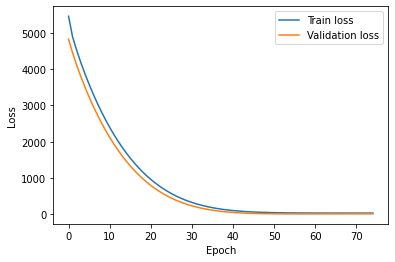

In [59]:
plt.plot(training_loss_over_epochs, label="Train loss")
plt.plot(validation_loss_over_epochs, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [60]:
test_set_predictions = rnn_model(test_x_tensor).detach().numpy()

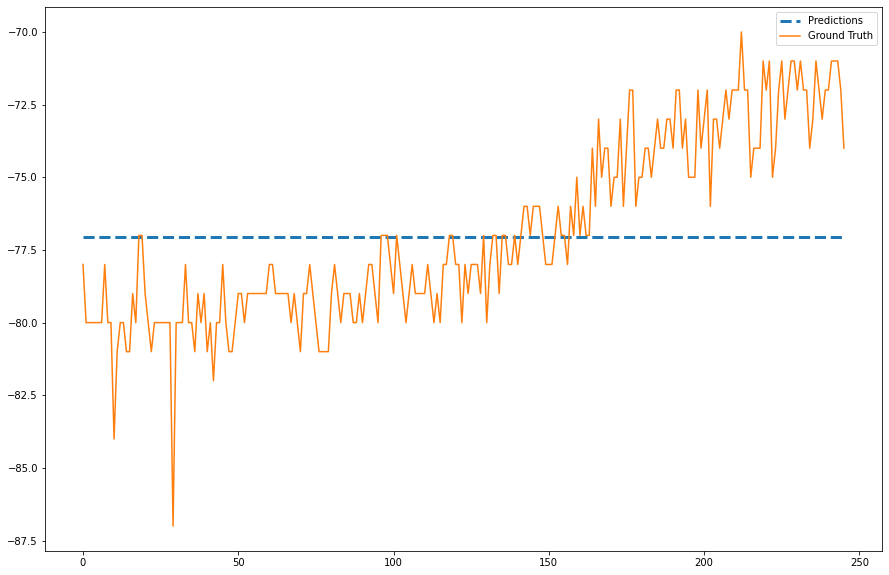

In [61]:
plt.figure(figsize=(15, 10))
plt.plot(test_set_predictions, "--", label="Predictions",linewidth=3)
plt.plot(test_y_tensor.numpy(), "-", label="Ground Truth")
plt.legend()
plt.show()

In [63]:
test_set_predictions

array([[-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.0506],
       [-77.

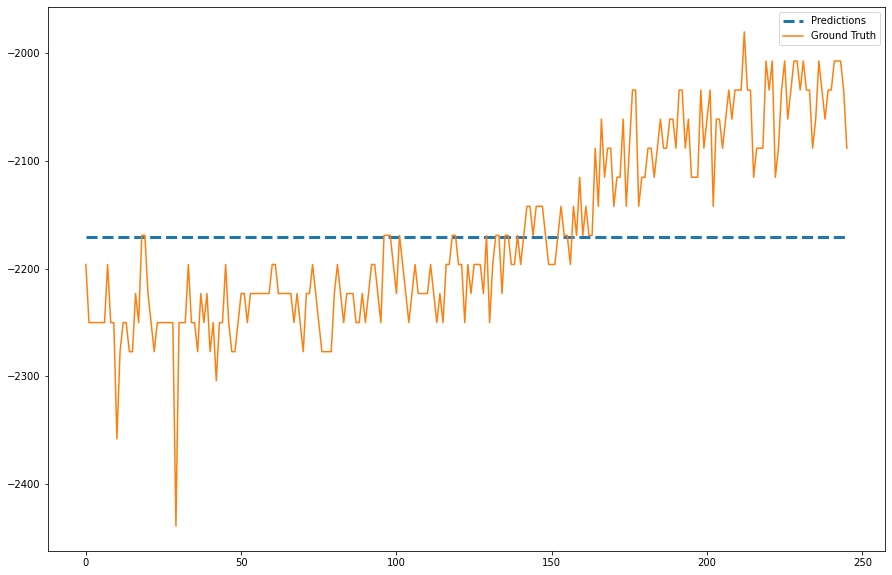

In [62]:
plt.figure(figsize=(15, 10))
plt.plot(scaler_y.inverse_transform(test_set_predictions), "--", label="Predictions",linewidth=3)
plt.plot(scaler_y.inverse_transform(test_y_tensor.numpy()), "-", label="Ground Truth")
plt.legend()
plt.show()

In [157]:
mae = sklearn.metrics.mean_absolute_error(scaler_y.inverse_transform(test_y_tensor.numpy()), scaler_y.inverse_transform(test_set_predictions))
mse = sklearn.metrics.mean_squared_error(scaler_y.inverse_transform(test_y_tensor.numpy()), scaler_y.inverse_transform(test_set_predictions))

In [158]:
metrics = {
    "MAE": mae, 
    "MSE": mse
}

In [159]:
metrics

{'MAE': 0.9827051, 'MSE': 1.7054207}